As an international student in the U.S., I am interested in forecasting the exchange rate of USD to INR. To achieve this, I plan to perform a time series analysis to predict the value of INR against USD over time

1. Getting the daily exchange rate data of USD to INR

In [2]:
import requests

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=FX_DAILY&from_symbol=USD&to_symbol=INR&apikey=yourappikeyhere&outputsize=full&datatype=csv'
r = requests.get(url)
print(r.status_code)
with open('forex.csv', 'wb') as f:
  f.write(r.content)




200


2. Loading the data to a pandas dataframe


In [3]:
import pandas as pd
df = pd.read_csv('forex.csv')
df.head()

,timestamp,open,high,low,close
0,2025-01-17,86.550,86.588,86.500,86.552
1,2025-01-16,86.349,86.599,86.349,86.550
2,2025-01-15,86.525,86.630,86.255,86.349
3,2025-01-14,86.626,86.675,86.445,86.515
4,2025-01-13,86.145,86.690,86.070,86.670


In [4]:
df.describe()

,open,high,low,close
count,2660.000000,2660.000000,2660.000000,2660.000000
mean,72.709026,72.882472,72.562846,72.717588
std,6.945180,6.930853,6.959360,6.948008
min,61.343000,61.555000,61.250000,61.343000
25%,66.739750,66.877500,66.618000,66.739750
50%,71.951000,72.196600,71.749500,71.969500
75%,78.929500,79.063500,78.769750,78.926750
max,86.626000,86.690000,86.500000,86.670000


In [5]:
df.shape

(2660, 5)

In [6]:
df.isna().sum()

,0
timestamp,0
open,0
high,0
low,0
close,0


I will be trying to predict the closing exchange rate of USD w.r.t INR.

In [7]:
df_close = df[['close']].copy()

In [8]:
df_close.head()

,close
0,86.552
1,86.550
2,86.349
3,86.515
4,86.670


The Augmented Dickey-Fuller (ADF) Test is a statistical test used to determine whether a time series is stationary or has a unit root. A time series is non-stationary if it exhibits a unit root, meaning the value at time t depends heavily on its previous value at time t-1. The ADF test checks for the presence of a unit root:

Null Hypothesis : The time series has a unit root (i.e., it is non-stationary).
Alternative Hypothesis : The time series does not have a unit root (i.e., it is stationary).
If the p-value is below a chosen significance level (e.g., 0.05), reject null hypothesis, concluding that the series is stationary.

In [9]:
from statsmodels.tsa.stattools import adfuller
print("ADF test p-value :", adfuller(df_close)[1])

ADF test p-value : 0.6582449781919015


Since p-value of ADF test is greater than 0.05, we can conclude that the series is non-stationary.

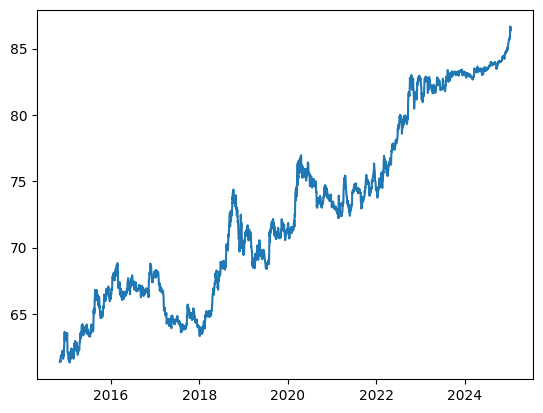

In [10]:
import matplotlib.pyplot as plt
df['timestamp'] = pd.to_datetime(df['timestamp'])
plt.plot(df['timestamp'],df['close'])
plt.show()

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Plotting the time series data showing the variation of exchange rate of USD w.r.t INR.

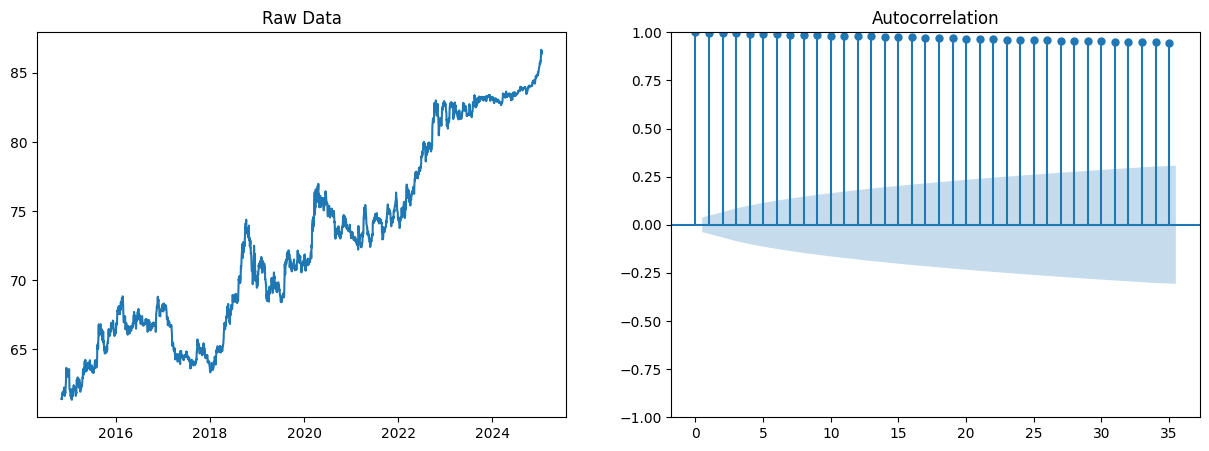

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(df['timestamp'],df['close'])
ax1.set_title('Raw Data')
plot_acf(df_close, ax=ax2)
plt.show()

To deal with non stationary, we apply differencing to the time series data.

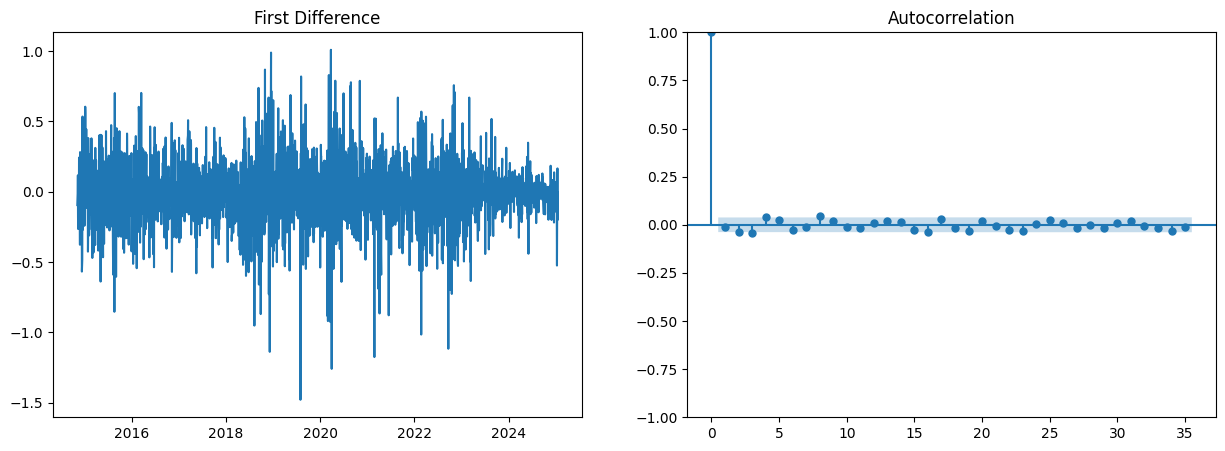

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(df['timestamp'],df['close'].diff())
ax1.set_title('First Difference')
plot_acf(df['close'].diff().dropna(), ax=ax2)
plt.show()

After applying differencing for a second time, we can see the correlation between the terms increased. So we take the differencing order to be 1. Therefore, d=1.

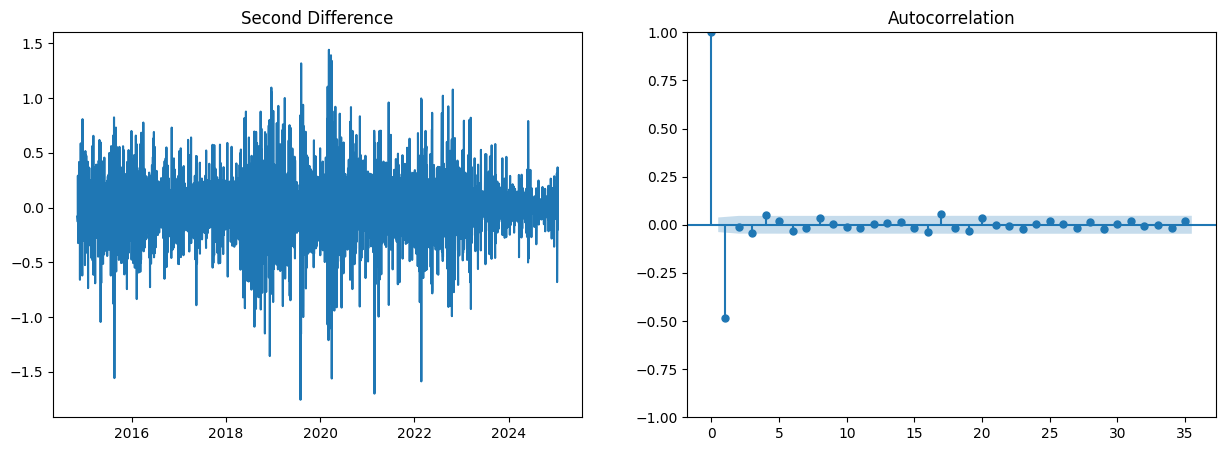

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(df['timestamp'],df['close'].diff().diff())
ax1.set_title('Second Difference')
plot_acf(df['close'].diff().diff().dropna(), ax=ax2)
plt.show()

From the above above acf plot we can see that the fourth lag term is slightly above the threshold so we can choose the MA term q=3.

We can also determine the differencing order using the pmdarima module.

In [18]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.8 MB/s eta 0:00:00


In [33]:
from pmdarima.arima import ndiffs
print('Suggested diffencing order:', ndiffs(df_close, test='adf'))

Suggested diffencing order: 1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

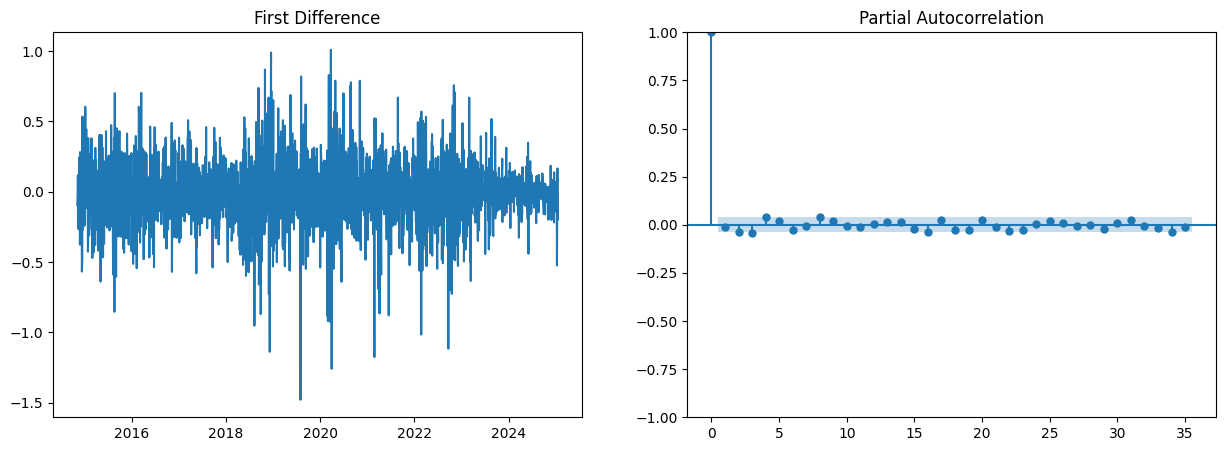

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(df['timestamp'],df['close'].diff())
ax1.set_title('First Difference')

plot_pacf(df['close'].diff().dropna(), ax=ax2)
plt.show()

Looking the pacf plot, we can see that the lag term number 3 or 4 is slightly greater that the threshold. So we can choose p=3 for our ARIMA model

In [41]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_close, order=(3,1,3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 2660
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 191.562
Date:                Fri, 17 Jan 2025   AIC                           -369.125
Time:                        05:28:34   BIC                           -327.925
Sample:                             0   HQIC                          -354.214
                               - 2660                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2751      0.422     -0.651      0.515      -1.103       0.553
ar.L2         -0.8345      0.074    -11.341      0.000      -0.979      -0.690
ar.L3         -0.3263      0.381     -0.856      0.3

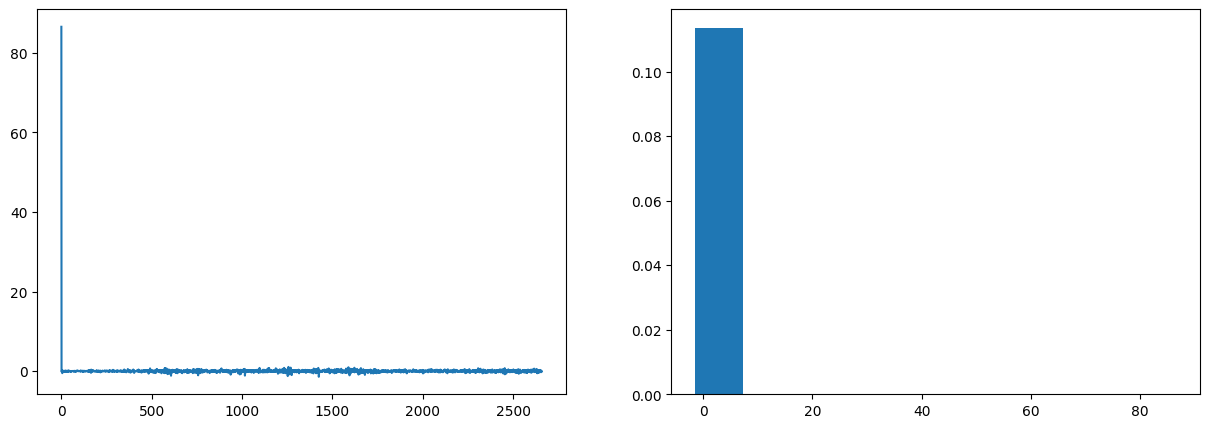

In [43]:
residuals = pd.DataFrame(model_fit.resid)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(residuals)
ax2.hist(residuals, density=True)
plt.show()

In [45]:
model_fit.plot_predict(dynamic=False)
plt.show()

AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'

In [22]:
from pmdarima import auto_arima
model = auto_arima(df['close'], seasonal=False, trace=True,
                   error_action='ignore', suppress_warnings=True)

print(model.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-373.214, Time=10.26 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-361.296, Time=0.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-359.524, Time=0.35 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-359.543, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-358.638, Time=0.17 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-360.701, Time=3.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-361.115, Time=5.93 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-373.907, Time=4.61 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-364.364, Time=2.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-371.944, Time=8.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-372.162, Time=6.48 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-373.276, Time=3.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-365.220, Time=6.72 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-370.135, Time=7.79 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-370.798, Time=3.14 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0] intercept
Total fit time: 63.281 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2660
Model:               SARIMAX(3, 1, 2)   Log Likelihood                 193.953
Date:                Fri, 17 Jan 2025   AIC                           -373.907
Time:                        05:03:22   BIC                           -332.707
Sample:                             0   HQIC                          -358.996
                               - 2660                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0176      0.008     -2.204      0.028      -0.033